In [116]:
#Import useful modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Ellipse
from PIL import Image
import random
from random import random as rnd
import time
import math
random.seed(time.time())

In [117]:
#Show image
def showImage(x, title):
    img = np.array(x, dtype=float)
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(title)

In [118]:
#Show heatmap
def showHeat(x, title):
    img = np.array(x, dtype=float)
    plt.figure()
    plt.imshow(img)
    plt.title(title)
    plt.colorbar()

# Problem generation

### Fourier modulus constraint generation

In [119]:
# variables
bordersize = 50
imagedim = (100,100)
filename = "shepplogan.png"
#filename = "starrynight.jpg"

In [120]:
# Read image and create another to match provided requirements
img = Image.open(filename).resize(imagedim).convert('L')
img.save(filename.split(".")[0]+"edited.png")

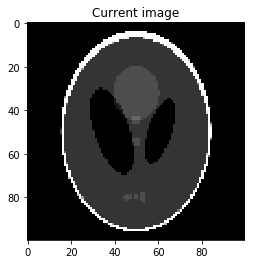

In [121]:
# load image into matplotlib
img = mpimg.imread(filename.split(".")[0]+"edited.png")
showImage(img, "Current image")

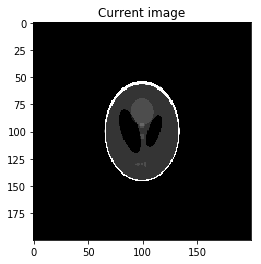

In [122]:
#Add black border to image
img = np.pad(img, pad_width=bordersize, mode='constant', 
               constant_values=0) 
showImage(img, "Current image")

In [123]:
# Computer fourier transform/absolute value:
b = np.abs(np.fft.fft2(img, norm='ortho'))
print("Fourier modulus values:")
print(b)

Fourier modulus values:
[[6.277843   5.183039   2.6062095  ... 0.21035476 2.6062095  5.183039  ]
 [4.264635   3.4014568  1.3944132  ... 0.59810835 1.4179412  3.3938344 ]
 [0.5715485  0.34814143 0.8250916  ... 1.349629   0.9867309  0.5319458 ]
 ...
 [1.746709   1.7447344  1.5694392  ... 0.98261416 1.4935846  1.6928184 ]
 [0.57154846 0.5319458  0.9867309  ... 1.2511696  0.8250916  0.34814143]
 [4.264635   3.3938344  1.4179412  ... 0.44145888 1.3944132  3.4014568 ]]


### Support constraint generation

In [124]:
#Used to generate ellipse support constraint (i.e. white ellipse surrounded by black), parameters = width, height
def generateEllipse(w, h):
    ovalsupp = np.array([[0 for i in range(imagedim[0] + bordersize*2)] for j in range (imagedim[1] + bordersize*2)])
    iw = len(ovalsupp)
    ih = len(ovalsupp[0])
    for i in range(iw):
        for j in range(ih):
            #Add 0.5 "correction" to get to middle of each cell since the center of each cell since indices are 0-indexed
            xc = (iw/2)-j+0.5
            yc = (ih/2)-i+0.5
            if ((xc**2)/((w/2)**2)) + ((yc**2)/((h/2)**2)) <= 1:
                ovalsupp[i][j] = 1
    return ovalsupp

Support:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


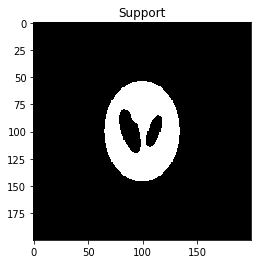

In [125]:
# Perfect support
supp = (img != 0).astype(int)

# Square border with border differing from initial border by extra
#extra = 20
#supp = np.pad([[1 for j in range(imagedim[1]-extra)] for i in range(imagedim[0]-extra)], pad_width=bordersize+extra//2, mode='constant', constant_values=0)

# Oval support (mainly useful for shepp logan since it's oval in shape to begin with)
#supp = generateEllipse(80, 100)

# Any of the above but some pixels have a chance to be wrong (maybe this simulates some kind of signal noise?)
# Set random_chance to false for this to not happen
random_chance = False
on_to_off = 0.05
off_to_on = 0.05
if(random_chance):
    random.seed(time.time())
    for i in range(len(supp)):
        for j in range(len(supp[i])):
            if supp[i][j] == 1 and rnd() < on_to_off:
                supp[i][j] = 0
            if supp[i][j] == 0 and rnd() < off_to_on:
                supp[i][j] = 1

print("Support:")
print(supp)
showImage(supp, "Support")

# Algorithms

In [126]:
# Algorithm variables

numiterations = 1000
maxdist = 1e-4

#Number of iterations between each printing of current result
displayperiod = 250

#The last [averageover] results will be averaged to produce "Final averaged image"
averageover = 100

### Projections

In [127]:
# projection onto image modulus constraint
def proj_c1(x):
    Fx = np.fft.fft2(x, norm='ortho')
    corrected = b * math.e**(1j*np.angle(Fx))
    #corrected = b*Fx/(np.abs(Fx)+1e-12)
    return np.fft.ifft2(corrected, norm='ortho')

In [128]:
# projection onto real number & non-negativity & support constraint
def proj_c2(x):
    return supp*(np.real(x).clip(min=0))

In [129]:
# projection onto real number & non-negativity ONLY (not used anywhere)
def real_nn(x):
    return np.real(x).clip(min=0)

### Stopping conditions

In [130]:
def stop_cond1(cnt):
    return (cnt < numiterations)

In [131]:
def stop_cond2(dist):
    return (dist > maxdist)

### Initial point (support)

In [132]:
def initialPoint():
    x = np.array([[supp[i][j] for j in range(len(supp[0]))] for i in range(len(supp))])
    showImage(x, "Initial image")
    return x

### 1) Error reduction algorithm (a.k.a. method of alternating projections)

Number of iterations: 1000 Final distance: 0.00026785226487206293


Text(0.5, 1.0, 'Log of error between terms of the sequence')

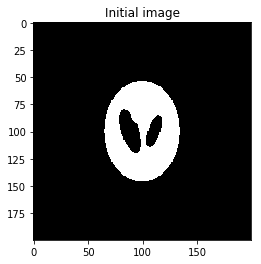

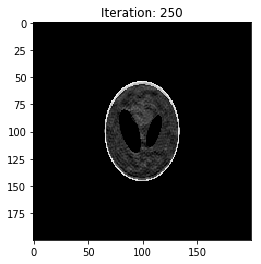

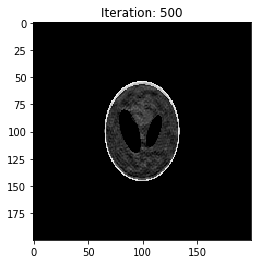

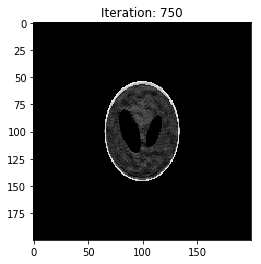

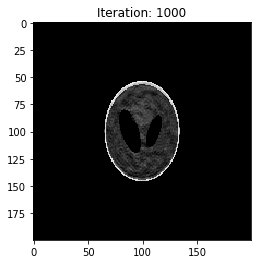

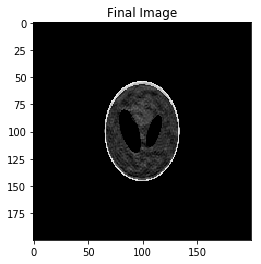

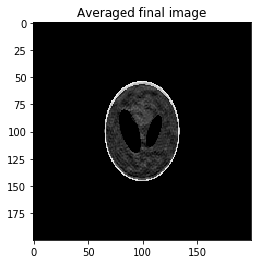

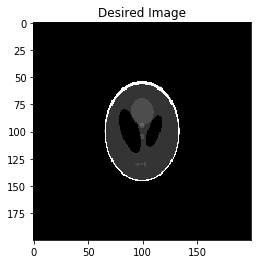

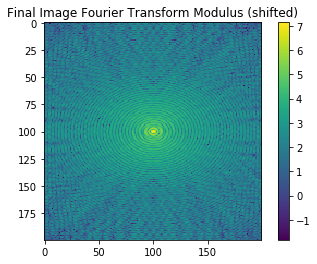

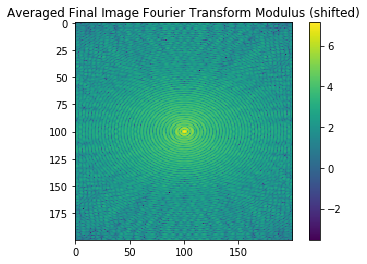

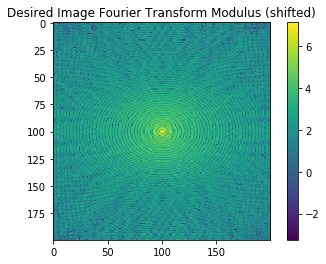

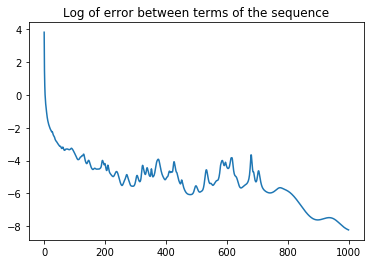

In [133]:
cnt = 0
dist = 1e12
finalX = []
x = initialPoint()
err = []
while(stop_cond1(cnt)):
    #print(dist)
    #print(cnt)
    xinit = x
    x = proj_c1(x)
    x = proj_c2(x)
    dist = np.linalg.norm(x-xinit)
    err.append(dist)
    cnt += 1
    if(cnt%displayperiod == 0):
        showImage(x, "Iteration: " + str(cnt))
    if(cnt >= averageover):
        finalX.append(x)
average = np.mean(finalX,axis=0)
showImage(x, "Final Image")
showImage(average, "Averaged final image")
showImage(img, "Desired Image")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(x)))),"Final Image Fourier Transform Modulus (shifted)")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(average)))),"Averaged Final Image Fourier Transform Modulus (shifted)")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(img)))),"Desired Image Fourier Transform Modulus (shifted)")
print("Number of iterations:", cnt, "Final distance:", dist)
plt.figure()
plt.plot(np.log(err))
plt.title("Log of error between terms of the sequence")

### 2) Fienup's Basic Input-Output Algorithm (a.k.a. Dykstra's algorithm)

Number of iterations: 1000 Final distance: 0.8617327055175824


Text(0.5, 1.0, 'Log of error between terms of the sequence')

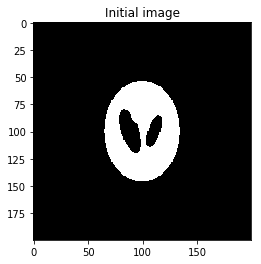

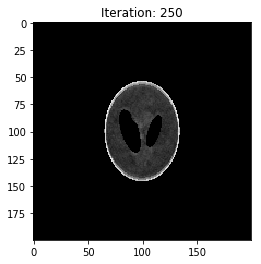

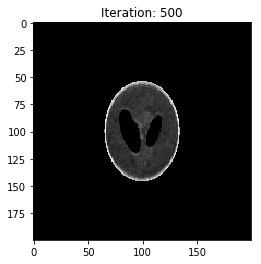

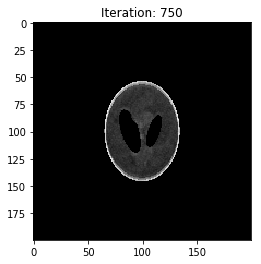

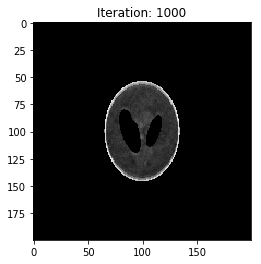

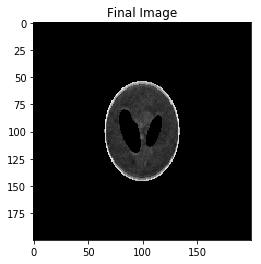

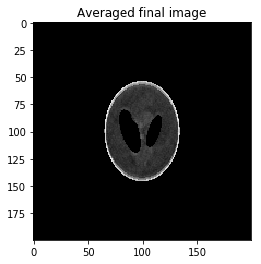

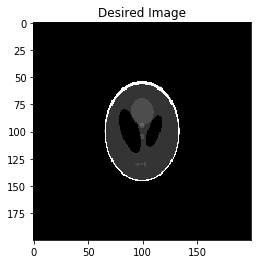

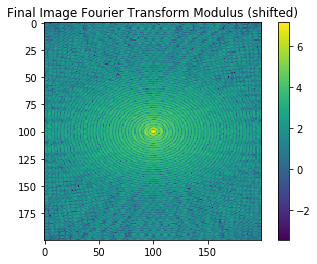

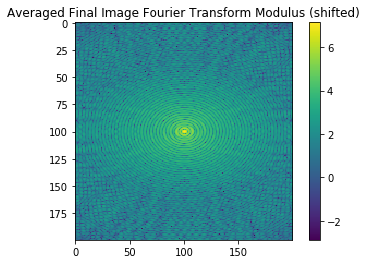

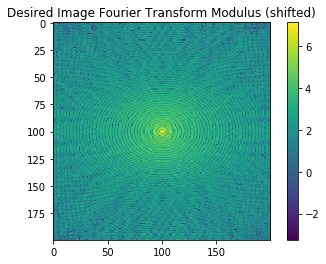

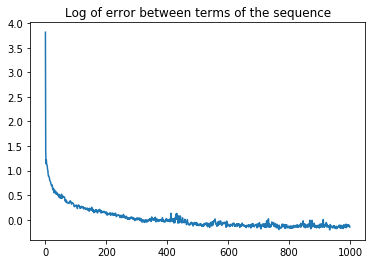

In [134]:
cnt = 0
dist = 1e12
finalX = []
err = []
an = initialPoint()
qn = 0
pn = 0

#Closed convex set A = convex object constraint, B = fourier domain constraint, so PA = proj_c2, PB = proj_c1
while(stop_cond1(cnt)):
    #print(dist)
    #print(cnt)
    ainit = an
    bn = proj_c1(an + qn)
    qn = an + qn - bn
    an = proj_c2(bn + pn)
    pn = bn + pn - an
    dist = np.linalg.norm(an-ainit)
    err.append(dist)
    cnt += 1
    if(cnt%displayperiod == 0):
        showImage(proj_c2(an), "Iteration: " + str(cnt))
    if(cnt >= averageover):
        finalX.append(proj_c2(an))
average= np.mean(finalX,axis=0)
showImage(proj_c2(an), "Final Image")
showImage(average, "Averaged final image")
showImage(img, "Desired Image")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(proj_c2(an))))),"Final Image Fourier Transform Modulus (shifted)")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(average)))),"Averaged Final Image Fourier Transform Modulus (shifted)")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(img)))),"Desired Image Fourier Transform Modulus (shifted)")
print("Number of iterations:", cnt, "Final distance:", dist)
plt.figure()
plt.plot(np.log(err))
plt.title("Log of error between terms of the sequence")

### 3) Fineup's Hybrid Input-Output Algorithm (a.k.a. Douglas-Rachford Algorithm)

Number of iterations: 1000 Final distance: 0.003428859367448899


Text(0.5, 1.0, 'Log of error between terms of the sequence')

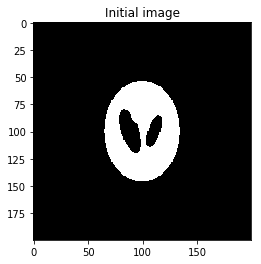

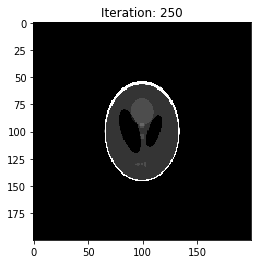

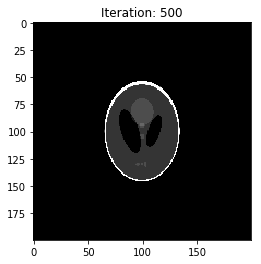

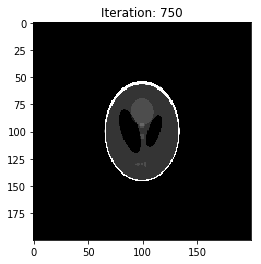

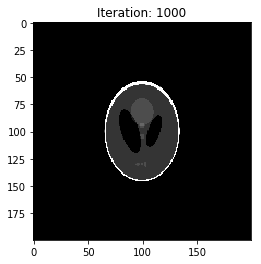

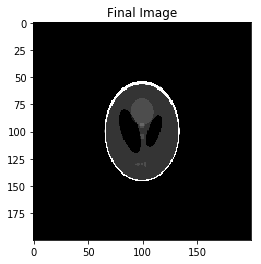

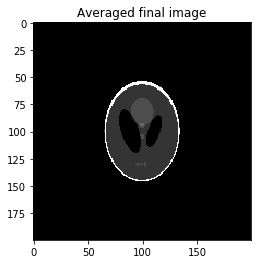

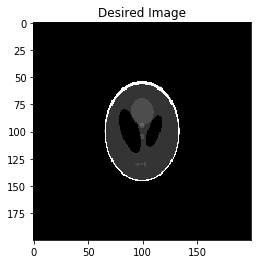

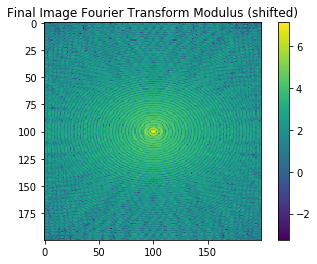

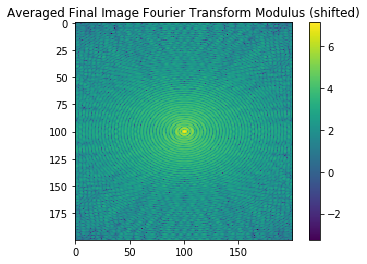

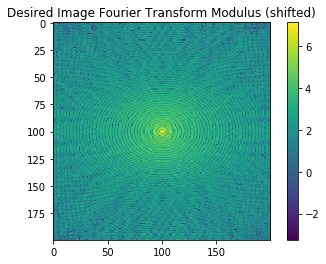

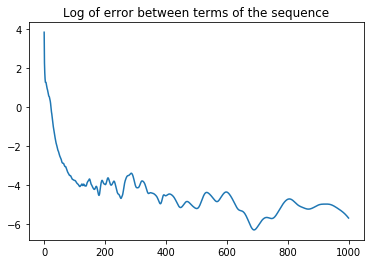

In [135]:
cnt = 0
dist = 1e12
finalX = []
err = []
x = initialPoint()

beta = 1

while(stop_cond1(cnt)):
    #print(dist)
    #print(cnt)
    xinit = x
    PmX = proj_c1(x)
    x = proj_c2(PmX) + x - beta*PmX - proj_c2(x) + beta*proj_c2(PmX)
    dist = np.linalg.norm(x-xinit)
    err.append(dist)
    cnt += 1
    if(cnt%displayperiod == 0):
        showImage(proj_c2(x), "Iteration: " + str(cnt))
    if(cnt >= averageover):
        finalX.append(proj_c2(x))
x = proj_c2(x)
average= np.mean(finalX,axis=0)
showImage(x, "Final Image")
showImage(average, "Averaged final image")
showImage(img, "Desired Image")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(proj_c2(x))))),"Final Image Fourier Transform Modulus (shifted)")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(average)))),"Averaged Final Image Fourier Transform Modulus (shifted)")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(img)))),"Desired Image Fourier Transform Modulus (shifted)")
print("Number of iterations:", cnt, "Final distance:", dist)
plt.figure()
plt.plot(np.log(err))
plt.title("Log of error between terms of the sequence")